In [1]:
import json
import csv
import glob
import pandas as pd
import numpy as np
import os
import shutil

from PIL import Image
import matplotlib.pyplot as plt

path = './data/stag-hunt-default-rtdb-export (1).json'

In [2]:
#load data from the json file
with open(path) as train_file:
    data = json.load(train_file)

# Survay results:

upload Id workers and search for duplicate workers

In [3]:
raw_df_state_to_action = pd.DataFrame.from_dict(data['humanModel'], orient='index')
raw_df_state_to_action = raw_df_state_to_action.drop(0, axis=1)

participants_df = pd.DataFrame.from_dict(data['all-games'], orient='index')

path = 'data/workers' # use your path
all_files = glob.glob(path + "/*.csv")

li = []
for filename in all_files:
    fromOne = pd.read_csv(filename, index_col=None, header=0)
    fromOne['filename'] = filename
    li.append(fromOne)

workers = pd.concat(li, axis=0, ignore_index=True)
workers = workers.set_index('Answer.surveycode')
workers.index = workers.index.map(lambda code: '-' + code[:-3])
print(workers.index[workers.index.duplicated()])
workers = workers[~workers.index.duplicated(keep='first')]
participants_df['WorkerId'] = workers['WorkerId']
participants_df = participants_df.dropna(subset = ['WorkerId'])
participants_df.head()

Index([], dtype='object', name='Answer.surveycode')


,WorkerId,additional_comments,behavior,birth_year,collaborative_value,computer_score,computer_value,education,gender,human_score,predictable_value,selfishly_value,wisely_value
-N2gl9wHXMJoXRg5OyiP,A6Y7SZU9L301W,,follow_stag,1980,4,51,7,BA,male,56,6,1,4
-N2gnbwu9gs6PgpScg-B,A3RHJEMZ4EGY2U,,follow_stag,1994,7,29,7,BA,female,46,4,1,4
-N2gpqCiV6iClR2iJfDD,APIUR4WD44BQ1,good,follow_stag,1975,5,10,4,Master's degree,male,15,6,4,5
-N2gzRD6MoUAWRj3PaOV,AJ9IY4IHOGB8,no,follow_stag,1988,5,9,1,BA,male,10,6,6,5
-N2h6FFFrGGqFAUIRi6W,A2JPO11US5Q4H4,good,follow_stag,1988,6,0,6,BA,female,6,6,6,6


In [4]:
participants_df.columns

Index(['WorkerId', 'additional_comments', 'behavior', 'birth_year',
       'collaborative_value', 'computer_score', 'computer_value', 'education',
       'gender', 'human_score', 'predictable_value', 'selfishly_value',
       'wisely_value'],
      dtype='object')

In [5]:
participants_df.shape

(136, 13)

In [6]:
raw_df_state_to_action.shape

(144, 71)

In [7]:
index_to_drop = participants_df[participants_df.duplicated('WorkerId', keep='first')].index
print(len(index_to_drop))

participants_df = participants_df[~participants_df.duplicated('WorkerId', keep='first')]

0


number of people that answer the survay only once:

In [8]:
len(participants_df)

136

In [9]:
participants_df[['additional_comments', 'behavior']][participants_df['additional_comments'].notna()][participants_df['additional_comments'] != ""].tail()

,additional_comments,behavior
-N60ETyUPyoTeUbk2ErQ,Impressive,closest
-N60HPdF56iDJ01ollY0,None,follow_stag
-N60KUIWwsqc8zGiFzNG,no,random
-N60Tx4zmO5_1Fgp6JlT,It was hard to decide where the blue player wa...,closest
-N613eK641CjDIG7Sh5G,none,random


In [10]:
participants_df.loc[: ,'human_score'] = pd.to_numeric(participants_df['human_score'], errors='coerce')
participants_df.loc[: ,'computer_score'] = pd.to_numeric(participants_df['computer_score'], errors='coerce')
participants_df.loc[: ,'collaborative_value'] = pd.to_numeric(participants_df['collaborative_value'], errors='coerce')
participants_df.loc[: ,'predictable_value'] = pd.to_numeric(participants_df['predictable_value'], errors='coerce')
participants_df.loc[: ,'selfishly_value'] = pd.to_numeric(participants_df['selfishly_value'], errors='coerce')
participants_df.loc[: ,'wisely_value'] = pd.to_numeric(participants_df['wisely_value'], errors='coerce')
participants_df.loc[: ,'computer_value'] = pd.to_numeric(participants_df['computer_value'], errors='coerce')

In [11]:
participants_df.groupby('behavior')[['computer_score', 'human_score', 'collaborative_value', 'predictable_value', 'selfishly_value', 'wisely_value', 'computer_value']].mean()

,computer_score,human_score,collaborative_value,predictable_value,selfishly_value,wisely_value,computer_value
behavior,,,,,,,
closest,27.875000,21.708333,3.416667,4.125000,4.625000,4.145833,5.562500
follow_stag,29.000000,39.111111,5.333333,5.000000,2.861111,4.777778,5.333333
random,8.269231,21.750000,3.519231,3.788462,4.192308,3.211538,5.923077


In [12]:
participants_df[['computer_score', 'human_score', 'behavior']].to_excel("data/all_agents_score.xlsx")

In [13]:
participants_df['behavior'].value_counts()

random         52
closest        48
follow_stag    36
Name: behavior, dtype: int64

In [14]:
participants_df['gender'].value_counts()

male      93
female    43
Name: gender, dtype: int64

In [15]:
participants_df['education'].value_counts()

BA                 86
High School        24
Master's degree    22
Ph.D                4
Name: education, dtype: int64

In [16]:
# not_follow_stag_indexes = participants_df[participants_df['behavior'] != "follow_stag"].index

# View some data

In [17]:
# remove from the dataset :
index_to_drop = [x for x in raw_df_state_to_action.index if x not in participants_df.index]
print(index_to_drop)

['-N2go9oI810XlH5aM5rn', '-N3uSY8tzzjOFSSewL0q', '-N3uVri6_hzdQY7CEjxF', '-N3uYLhPbwSpx5ynRJnZ', '-N3uZmM8GV86vUX5TbTO', '-N60AuB8HHGmcjvguDUD', '-N60EmaO4DzgOwGJ1-hX', '-N7RkJlcrmJTE5V8uBG6']


In [18]:
raw_df_state_to_action = raw_df_state_to_action.drop(index_to_drop)
# raw_df_state_to_action = raw_df_state_to_action.drop(not_follow_stag_indexes)
raw_df_state_to_action.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 136 entries, -N2gl9wHXMJoXRg5OyiP to -N613eK641CjDIG7Sh5G
Columns: 71 entries, 1 to 71
dtypes: object(71)
memory usage: 76.5+ KB


In [19]:
map_size = [5,5]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def extractAction(cell):
    if cell != None:
        return int(cell['humanAction'])
    return np.nan

def extractState(cell):
    if cell == None:
        return cell
    
    if any(x > 4 for x in cell['stateCoords']):
        print('cell is not valid: ', cell)
        return
    cell = cell['stateCoords']
    r = np.zeros(map_size)
    g = np.zeros(map_size)
    b = np.zeros(map_size)
    # computer pos    
    b[cell[0], cell[1]] += 1
    # human pos
    r[cell[2], cell[3]] += 1
    # stag pos
    r[cell[4], cell[5]] += 0.5
    g[cell[4], cell[5]] += 0.5
    b[cell[4], cell[5]] += 0.5
    # plants pos
    for i in range(6, 12, 2):
        g[cell[i], cell[i+1]] += 1

    return np.dstack((r,g,b))
    # return NormalizeData(np.dstack((r,g,b)))
    
state_df = pd.DataFrame(columns=raw_df_state_to_action.columns)
action_df = pd.DataFrame(columns=raw_df_state_to_action.columns)
for col in raw_df_state_to_action:
    state_df[col] = raw_df_state_to_action[col].apply(extractState)
    action_df[col] = raw_df_state_to_action[col].apply(extractAction)

In [20]:
action_df[(action_df.count(axis=1) > 60)]

,1,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71


In [21]:
def combine_following_states(cell1, cell2):
    r2, g2, b2 = cell2[:, :, 0], cell2[:, :, 1], cell2[:, :, 2]
    human_pos = np.where((r2 == 1) | (r2 == 1.5))
    computer_pos = np.where((b2 == 1) | (b2 == 1.5))
    bushes_pos = np.where((g2 == 1) | (g2 == 1.5))
    stag_pos = np.where(((r2 == 0.5) & (g2 == 0.5) & (b2 == 0.5)) |
                        ((r2 == 1.5) & (g2 == 0.5) & (b2 == 0.5)) |
                        ((r2 == 0.5) & (g2 == 1.5) & (b2 == 0.5)) |
                        ((r2 == 0.5) & (g2 == 0.5) & (b2 == 1.5)))

    new_cell = cell1 * 0.9

    new_cell[:, :, 0][human_pos] = 1
    new_cell[:, :, 1] = np.zeros(map_size)
    new_cell[:, :, 1][bushes_pos] = 1
    new_cell[:, :, 2][computer_pos] = 1

    new_cell[:, :, 0][stag_pos] += 0.5
    new_cell[:, :, 1][stag_pos] += 0.5
    new_cell[:, :, 2][stag_pos] += 0.5

    return NormalizeData(new_cell)

new_state_df = state_df.copy()
for (idxRow, s1), (_, s2) in zip(state_df.iterrows(), action_df.iterrows()):
    for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
        # check if it is not the last state
        # the last state not enter our model, since it is an end state that not contains any dirts and not preform an action
        if not np.isnan(action_df.loc[idxRow, idxCol]):
            if idxCol == 1:
                continue
            else:
            # new_state_df.loc[idxRow, idxCol], history = combine_following_states(history, new_state_df.loc[idxRow, idxCol])
                new_state_df.loc[idxRow, idxCol] = combine_following_states(new_state_df.loc[idxRow, idxCol-1], new_state_df.loc[idxRow, idxCol])

# view one game

In [22]:
def rowToImage(row, col=61):
    fig = plt.figure(figsize=(80, 80))
    row_s = new_state_df.loc[row, :col]
    row_a = action_df.loc[row, :col]
    cols_i = row_a.count()
    for i in range(1, cols_i+1):
        rows = 1
        columns = cols_i
        state = row_s.at[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(state)
        plt.axis('off')
        action = row_a.at[i]
        plt.title(str(i) + " action: " + str(action), fontsize=8)

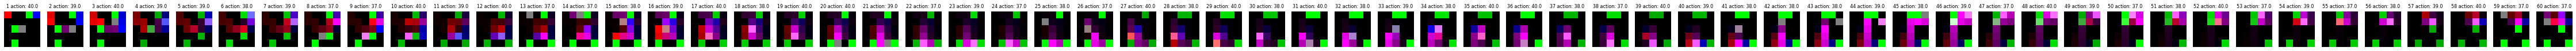

In [23]:
rowToImage('-N2gl9wHXMJoXRg5OyiP')

In [24]:
action_df[len(action_df.columns) + 1] = np.NaN
action_df.tail()

,1,2,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,72
-N60KuKmqPd_41fLQthi,40,40,40,40,39,39,39,39,38,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-N60Tx4zmO5_1Fgp6JlT,40,39,39,40,40,40,39,39,37,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-N60UdZtsvjhImC1NplA,39,40,39,39,37,39,39,40,37,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-N611yMxdy44Ur-GYHEH,40,40,40,39,40,39,39,39,37,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-N613eK641CjDIG7Sh5G,40,39,39,39,40,40,40,37,37,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Make Dataset

dataset_v1:

In [25]:
# # dir_path = './data/humanModel/dataset_v0.csv'
# # if os.path.exists(dir_path):
# #   os.remove(dir_path)

# # rows = [
# # ["code", "step", "computer_x", "computer_y", "human_x", "human_y", "stag_x", "stag_y", "shrub1_x", "shrub1_y", "shrub2_x", "shrub2_y", "shrub3_x", "shrub3_y", "human_action"] #, "computer_action", "stag_action"]
# # ]
# # counter = 0
# # for (idxRow, s1), (_, s2) in zip(state_df.iterrows(), action_df.iterrows()):
# #     for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
# #         # check if it is not the last state
# #         # the last state not enter our model, since it is an end state that not contains any dirts and not preform an action
# #         if not np.isnan(action_df.loc[idxRow, idxCol+1]):
# #             row = flatten([[idxRow, idxCol], flatten(state), [int(action)]])
# #             if counter % 500 == 0:
# #                 # print every 500 saved images
# #                 print(row)
# #             counter += 1
# #             rows.append(row)
# #         else:
# #             break
# # print(f'{counter} rows have been saved')
# # np.savetxt(dir_path, 
# #            rows,
# #            delimiter =", ", 
# #            fmt ='% s')

# dir_path = './data/humanModel/dataset'
# if os.path.exists(dir_path):
#     shutil.rmtree(dir_path)
# os.mkdir(dir_path)
# for action in ['37','38','39','40']:
#     os.mkdir(dir_path+'/'+action)

# # open the file in the write mode
# f = open(dir_path+'/participants_rate.csv', 'w')
# # create the csv writer
# writer = csv.writer(f)

# counter = 0
# for (idxRow, s1), (_, s2) in zip(new_state_df.iterrows(), action_df.iterrows()):
#     for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
#         # check if it is not the last state
#         if not np.isnan(action_df.loc[idxRow, idxCol]):
#             im = Image.fromarray((state * 255).astype(np.uint8))
#             value_vector_rate = participants_df.loc[idxRow, ['collaborative_value', 'computer_value', 'predictable_value', 'selfishly_value', 'wisely_value']]
#             path = f'data/humanModel/dataset/{int(action)}/{idxRow}_{idxCol}.png'
#             if counter % 500 == 0:
#                 # print every 500 saved images
#                 print(f'{idxRow}_{idxCol}.png saved! at action {action}')
#             counter += 1
#             im.save(path)

#             # write a vector to the csv file
#             writer.writerow(value_vector_rate)
#         else:
#             break
# #         print (state, action, idxCol, idxRow)
# print(f'{counter} images have been saved')

dataset_v2:

In [26]:
def next_position(action, position):
    if action == 32:
        return position
    elif action == 37:
      return [position[0], position[1]-1]
    elif action == 38:
      return [position[0]-1, position[1]]
    elif action == 39:
      return [position[0], position[1]+1]
    elif action == 40:
      return [position[0]+1, position[1]]
    
    raise RuntimeError("Unknown action: " + str(action))

In [27]:
def calc_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def calc_distance_closest_bush(pos1, poses):
    min_dis = calc_distance(pos1, poses[0])
    for i in range(1, len(poses)):
        dis = calc_distance(pos1, poses[i])
        if dis < min_dis:
            min_dis = dis
    return min_dis

def calc_distance_bushes(pos1, poses):
    return np.array([calc_distance(pos1, pos2) for pos2 in poses])

In [28]:
def find_lable(state, action):
    r2, g2, b2 = state[:, :, 0], state[:, :, 1], state[:, :, 2]
    human_pos = np.where((r2 == 1) | (r2 == 1.5))
    human_pos = [human_pos[0][0], human_pos[1][0]]
    bushes_pos = np.where((g2 == 1) | (g2 == 1.5))
    good_bushes_pos = []
    for i in range(3):
        good_bushes_pos.append([bushes_pos[0][i], bushes_pos[1][i]])
    bushes_pos = np.array(good_bushes_pos)    
    stag_pos = np.where(((r2 == 0.5) & (g2 == 0.5) & (b2 == 0.5)) |
                        ((r2 == 1.5) & (g2 == 0.5) & (b2 == 0.5)) |
                        ((r2 == 0.5) & (g2 == 1.5) & (b2 == 0.5)) |
                        ((r2 == 0.5) & (g2 == 0.5) & (b2 == 1.5)))
    stag_pos = [stag_pos[0][0], stag_pos[1][0]]


    dis_from_stag = calc_distance(human_pos, stag_pos)
    dis_from_bushes = calc_distance_bushes(human_pos, bushes_pos)
    
    next_human_pos = next_position(action, human_pos)
    next_dis_from_stag = calc_distance(next_human_pos, stag_pos)
    next_dis_from_bushes = calc_distance_bushes(next_human_pos, bushes_pos)

    dis = next_dis_from_bushes - dis_from_bushes
    if next_dis_from_stag < dis_from_stag and min(dis) < 0:
        # return "both"
        return "follow_stag"

    if next_dis_from_stag < dis_from_stag:
        return "follow_stag"
        
    if min(dis) < 0:
        return "closest_bush"

    # if next_dis_from_stag < dis_from_stag and next_dis_from_closest_bush < dis_from_closest_bush:
    #     return "both"
    # if next_dis_from_stag > dis_from_stag and next_dis_from_closest_bush > dis_from_closest_bush:
    #     return "none"

    # if next_dis_from_stag < dis_from_stag:
    #     return "follow_stag"
    # if next_dis_from_closest_bush < dis_from_closest_bush:
    #     return "closest_bush"


In [29]:
dir_path = './data/humanModel/dataset'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
os.mkdir(dir_path)
for action in ['follow_stag','closest_bush']:
    os.mkdir(dir_path+'/'+action)

# open the file in the write mode
f = open(dir_path+'/participants_rate.csv', 'w')
# create the csv writer
writer = csv.writer(f)

counter = 0
for (idxRow, s1), (_, s2) in zip(state_df.iterrows(), action_df.iterrows()):
    for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
        # check if it is not the last state
        if not np.isnan(action_df.loc[idxRow, idxCol]):
            im = Image.fromarray((state * 255).astype(np.uint8))
            value_vector_rate = participants_df.loc[idxRow, ['collaborative_value', 'computer_value', 'predictable_value', 'selfishly_value', 'wisely_value']]
            lable = find_lable(state, action)
            if lable in ['follow_stag','closest_bush']:
                path = f'data/humanModel/dataset/{lable}/{idxRow}_{idxCol}.png'
                if counter % 500 == 0:
                    # print every 500 saved images
                    print(f'{idxRow}_{idxCol}.png saved! at action {lable}')
                counter += 1
                im.save(path)

                # write a vector to the csv file
                writer.writerow(value_vector_rate)
            
        else:
            break
#         print (state, action, idxCol, idxRow)
print(f'{counter} images have been saved')

-N2gl9wHXMJoXRg5OyiP_1.png saved! at action follow_stag
-N2r2eHOlWQUjhi6Vwmr_41.png saved! at action follow_stag
-N2r88BIcmfxtBsTLr0b_8.png saved! at action follow_stag
-N2rFJaUBEW-ogbp31-__37.png saved! at action closest_bush
-N2rMt-8Tl-evxUxkjxv_10.png saved! at action closest_bush
-N3uSQ6fTBht1y-rRuwO_38.png saved! at action closest_bush
-N3uTLILjm_i072CABSD_6.png saved! at action closest_bush
-N3uX1XcMKevA5lV4OtI_39.png saved! at action follow_stag
-N3u_iicD2_G1Kr28Zak_17.png saved! at action follow_stag
-N3uhm198VZ44J_Vh6co_49.png saved! at action follow_stag
-N3um7bjC3bKz83A5QmH_21.png saved! at action follow_stag
-N3v7NW69veDQNJNnpaO_45.png saved! at action follow_stag
-N600-7WYheXOKVgUg4K_10.png saved! at action closest_bush
-N600kVz4mhm0haN1UoC_36.png saved! at action closest_bush
-N605MFTS2FjoN5Wl4nd_3.png saved! at action closest_bush
-N60ErvzvYx_bVSDKugG_29.png saved! at action follow_stag
-N613eK641CjDIG7Sh5G_54.png saved! at action closest_bush
8007 images have been saved

# fix scores:

In [ ]:
# # change the reward of cupturing the stag to 4

# # count the number of cupturing the stag



# def countCupturedStag(row):
#     counter = 0
#     # prev_computer_pos =
#     # prev_human_pos =
#     # prev_stag_pos =
#     for i in range(1, len(row)+1):
#       if row[i] == None: # game not ended
#         break

#       cell = row[i]

#       computer_action = cell['computerAction']
#       human_action = cell['humanAction']
#       stag_action = cell['stagAction']

#       computer_pos = [cell['stateCoords'][0], cell['stateCoords'][1]]
#       human_pos = [cell['stateCoords'][2], cell['stateCoords'][3]]
#       stag_pos = [cell['stateCoords'][4], cell['stateCoords'][5]]

#       next_computer_pos = next_position(computer_action, computer_pos)
#       next_human_pos = next_position(human_action, human_pos)
#       next_stag_pos = next_position(stag_action, stag_pos)
      
#       # print(row[i])

#       # print("next_computer_pos = ", next_computer_pos)
#       # print("next_human_pos = ", next_human_pos)
#       # print("next_stag_pos = ", next_stag_pos)

#       # print(row[i+1])

#       # assert 0 <= next_computer_pos[0] < 5 and 0 <= next_computer_pos[1] < 5, 'next_computer_pos must be between 5 and 0: '+ str(next_computer_pos) + "\n" + str(cell)
#       # assert 0 <= next_human_pos[0] < 5 and 0 <= next_human_pos[1] < 5, 'next_human_pos must be between 5 and 0: '+ str(next_human_pos) + "\n" + str(cell)
#       # assert 0 <= next_stag_pos[0] < 5 and 0 <= next_stag_pos[1] < 5, 'next_stag_pos must be between 5 and 0: '+ str(next_stag_pos) + "\n" + str(cell)

#       if next_human_pos == next_stag_pos == next_computer_pos:
#         counter += 1

#     # raise Exception
#     return counter
        
            
# def fix_scores(df):
#     rewards = {
#         'Stag': 5 - 3
#     }
#     c_h_scores = pd.DataFrame(index=df.index, columns=['computer_score', 'human_score'])
#     computer_scores = []
#     human_scores = []
#     for i, row in df.iterrows():
#         count_of_cuptured_stag = countCupturedStag(row)

#         coputerScore = participants_df.loc[i, 'computer_score'] + count_of_cuptured_stag * rewards['Stag']
#         humanScore = participants_df.loc[i, 'human_score'] +  count_of_cuptured_stag * rewards['Stag']
#         computer_scores.append(coputerScore)
#         human_scores.append(humanScore)

#     c_h_scores['computer_score'] = computer_scores
#     c_h_scores['human_score'] = human_scores
#     c_h_scores['computer_score_real'] = participants_df['computer_score']
#     c_h_scores['human_score_real'] = participants_df['human_score']
#     c_h_scores['behavior'] = participants_df['behavior']
#     return c_h_scores

# new_scores_df = fix_scores(raw_df_state_to_action)

In [ ]:
# new_scores_df.groupby('behavior').mean()

In [ ]:
# new_scores_df[['computer_score', 'human_score', 'behavior']].to_excel("data/all_agents_score.xlsx")

In [ ]:
# participants_df['computer_score'] = new_scores_df['computer_score']
# participants_df['human_score'] = new_scores_df['human_score']
# participants_df.to_json('new_table.json', orient="index")